In [161]:
#Load the csv file of the adult-income-dataset csv adult.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the adult dataset
adult_dataset = pd.read_csv('./adult.csv')

In [162]:
# Replace missing values denoted by '?' with NaN
adult_dataset.replace('?', np.nan, inplace=True)

# Drop rows with missing values
adult_dataset.dropna(inplace=True)

# Reset index after dropping rows
adult_dataset.reset_index(drop=True, inplace=True)

# Display the first few rows
print(adult_dataset.head())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   34    Private  198693          10th                6       Never-married   

          occupation   relationship   race gender  capital-gain  capital-loss  \
0  Machine-op-inspct      Own-child  Black   Male             0             0   
1    Farming-fishing        Husband  White   Male             0             0   
2    Protective-serv        Husband  White   Male             0             0   
3  Machine-op-inspct        Husband  Black   Male          7688             0   
4      Other-service  Not-in-family  White   Male             0             0   

   hours-per-week native-country

### Find Underrepresented groups
#### We will check for a two feature combinations from: 'race', 'native-country', 'gender', 'age'

In [163]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

def plot_heatmap_categorical(data, value1, value2):
    # Create a cross-tabulation of the two categorical values
    crosstab = pd.crosstab(data[value1], data[value2])
    
    # Calculate the frequency of each category
    freq = crosstab.apply(lambda r: r / r.sum(), axis=1)
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    if len(crosstab.columns) > 5:
        num_subplots = len(crosstab.columns) // 5 + 1
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))
        for i in range(num_subplots):
            start_idx = i * 5
            end_idx = min((i + 1) * 5, len(crosstab.columns))
            sub_crosstab = crosstab.iloc[:, start_idx:end_idx]
            ax = axes[i] if num_subplots > 1 else axes
            sns.heatmap(sub_crosstab, annot=True, fmt='d', cmap='RdBu', linewidths=0.5, linecolor='white', ax=ax, vmin=crosstab.min().min(), vmax=crosstab.max().max())
            ax.set_title(f'Counts of {value1} and {value2} (Part {i+1})')
            ax.set_xlabel(value2)
            ax.set_ylabel(value1)
        plt.tight_layout()
    else:
        sns.heatmap(crosstab, annot=True, fmt='d', cmap='RdBu', linewidths=0.5, linecolor='white', vmin=crosstab.min().min(), vmax=crosstab.max().max())
        plt.title(f'Counts of {value1} and {value2}')
        plt.xlabel(value2)
        plt.ylabel(value1)
    plt.show()

Find Underrepresented groups for race and gender

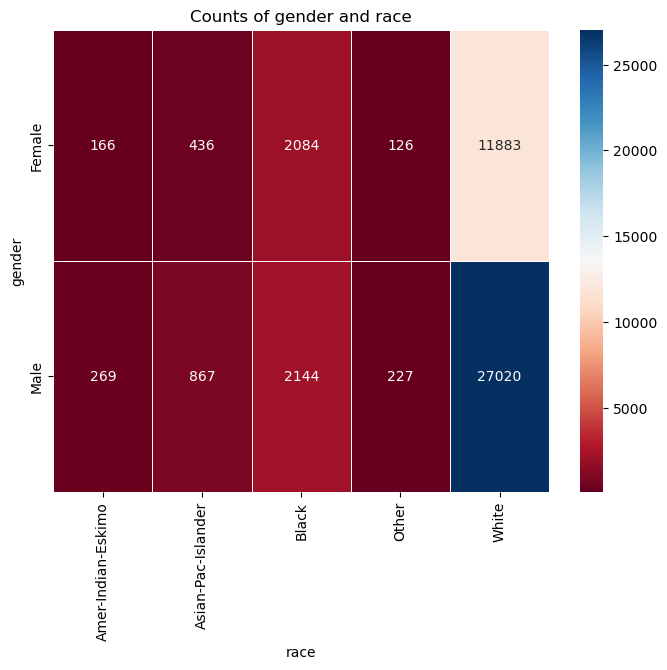

In [164]:
plot_heatmap_categorical(adult_dataset, 'gender', 'race')

We see general underrepresentation for Amer-Indian-Eskimo. 
We also see underrepresentation for female Asian-Pac-Islander

<Figure size 800x600 with 0 Axes>

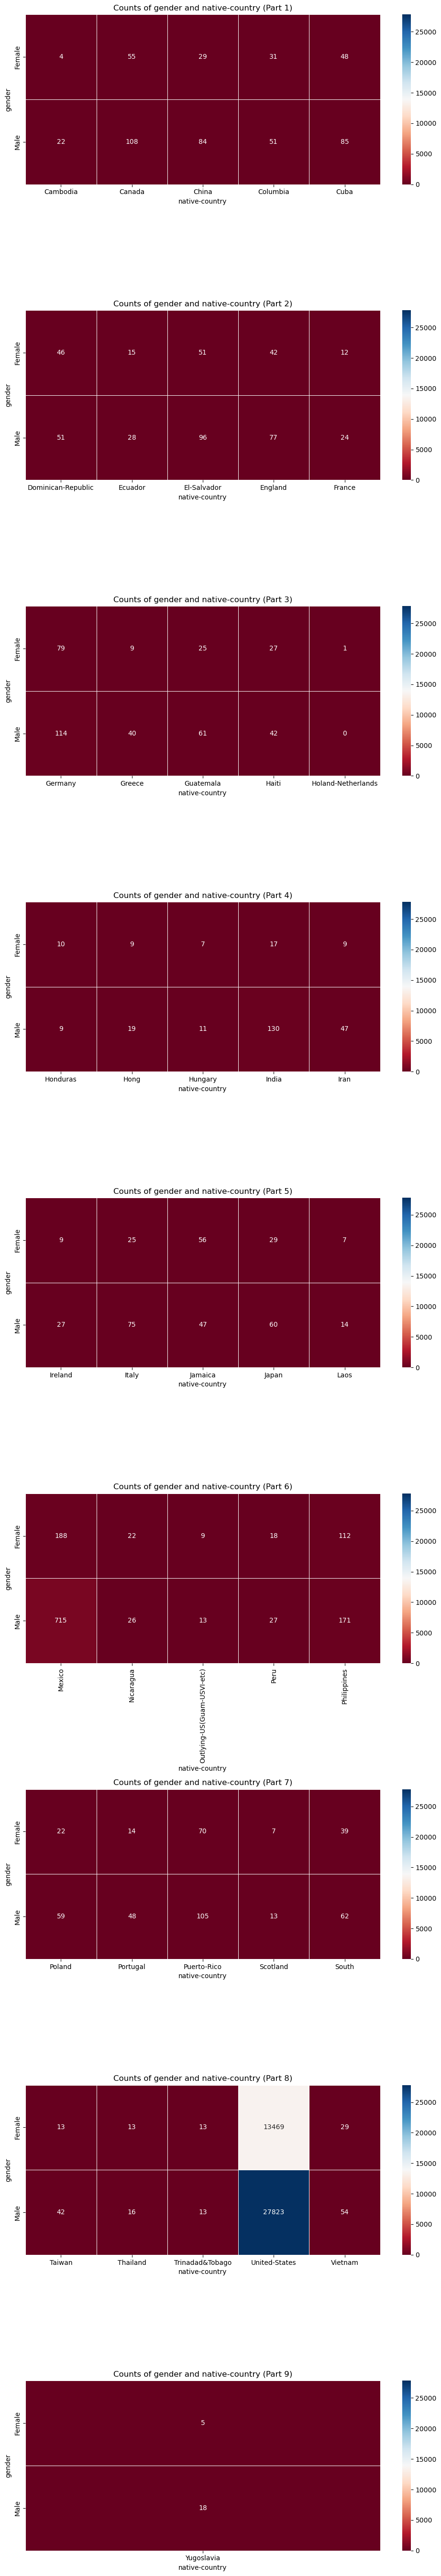

In [165]:
plot_heatmap_categorical(adult_dataset, 'gender', 'native-country')

We see that the United States is the most common native-country and it makes hard to understand the heatmap.
Lets understand if in general non-United-States is underrepresented.

In [166]:
# Calculate the pretcentage of non US citizens
non_us_citizens = adult_dataset[adult_dataset['native-country'] != 'United-States']
percentage = len(non_us_citizens) / len(adult_dataset) * 100
print(f'{percentage:.2f}% of the dataset are non US citizens')
print(f'the number of non US citizens is {len(non_us_citizens)}')

8.69% of the dataset are non US citizens
the number of non US citizens is 3930


There are 3930 non-US citizens samples in the data, which are 8.69%. For now we are not considering this entire category as underrepresented.
And so we now will enlarge the resolution.

/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Figure size 800x600 with 0 Axes>

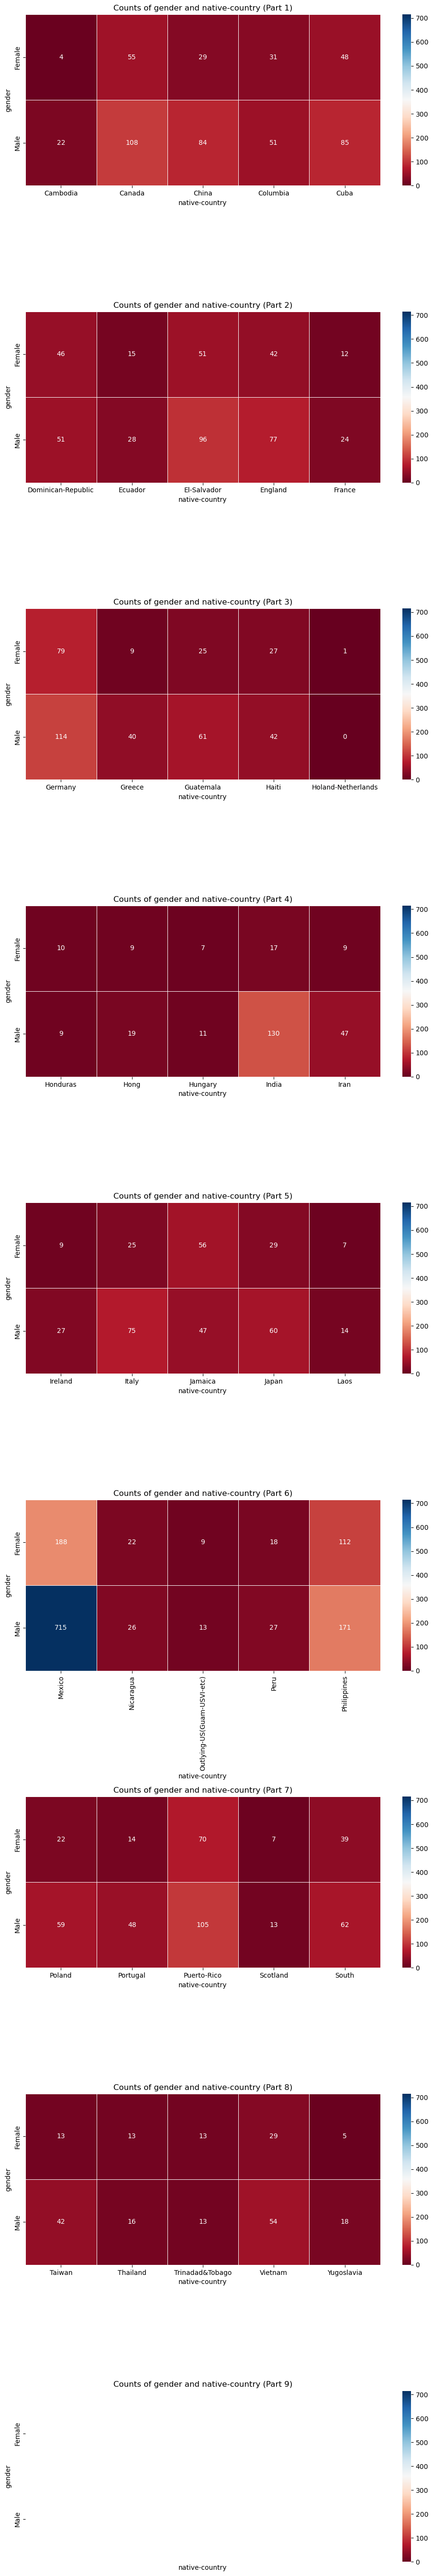

In [167]:
plot_heatmap_categorical(non_us_citizens, 'gender', 'native-country')

It is obvious now that each native-country other than the US (and maybe Mexico) can be considered underrepresented.
We will explore two options to continue.
The first is binning native-country into continents
The second is defining those all as underrepresented when synthesizing the new samples, and prompt the LLM to create samples for all non-US native-countries.

Because the native-countries is so split, we will move forward with the bins for now, especially when trying to find underrepresentation

In [168]:
def map_country_to_continent(country):
    continent_map = {
        'North America': ['United-States', 'Canada', 'Mexico','Outlying-US(Guam-USVI-etc)',],
        'Central America': [ 'Puerto-Rico', 'Honduras', 'Cuba', 'Dominican-Republic', 'Jamaica', 'El-Salvador', 'Haiti', 'Trinadad&Tobago'],
        'Asia': ['China', 'India', 'Japan', 'Philippines', 'Vietnam', 'South'],
        'Europe': ['England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 'Greece', 'Ireland'],
        'South America': ['Columbia', 'Ecuador', 'Peru'],
        'Africa': ['South-Africa', 'Egypt'],

    }

    for continent, countries in continent_map.items():
        if country in countries:
            return continent
    return 'Other'

adult_dataset['continent'] = adult_dataset['native-country'].apply(map_country_to_continent)

<Figure size 800x600 with 0 Axes>

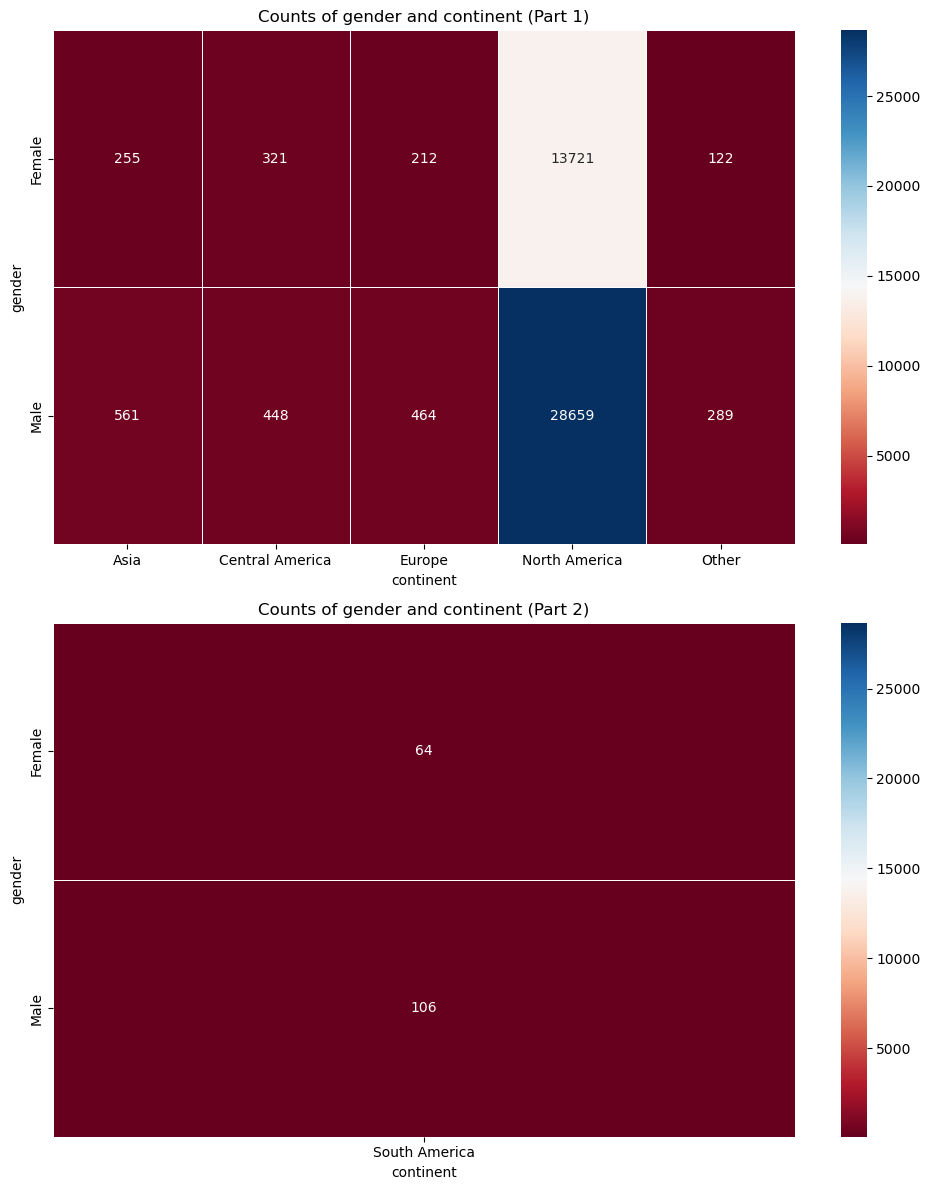

In [169]:
plot_heatmap_categorical(adult_dataset, 'gender', 'continent')

We again see that the US (North America) is by far the most represented, even after binning into continents.
We will remove the North-America like we did before to better visualize the data

/var/folders/g2/ml0k_lms1cv81jxqmk_c4gt40000gn/T/ipykernel_1565/1731633330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_us_citizens['continent'] = non_us_citizens['native-country'].apply(map_country_to_continent)


<Figure size 800x600 with 0 Axes>

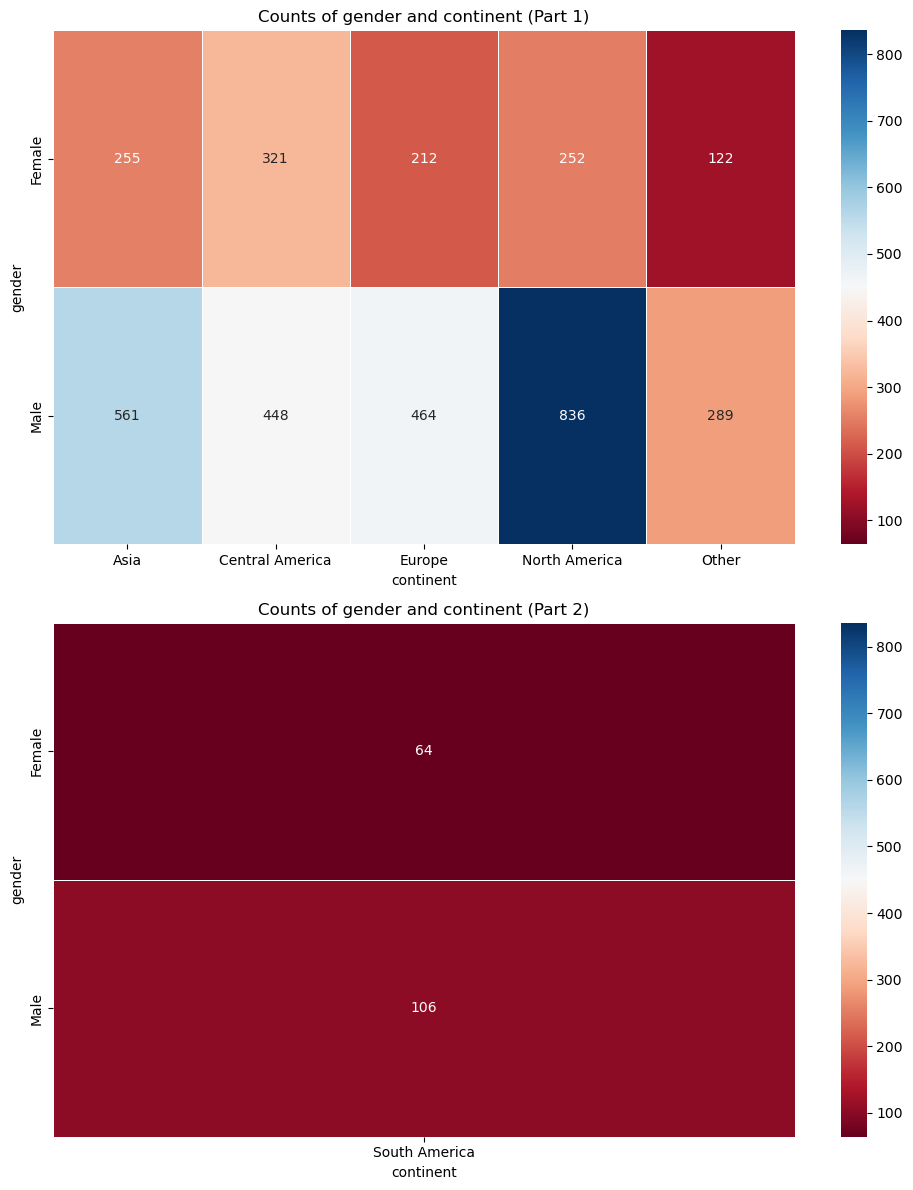

In [170]:
non_us_citizens['continent'] = non_us_citizens['native-country'].apply(map_country_to_continent)
plot_heatmap_categorical(non_us_citizens, 'gender', 'continent')

We now see that South America is the underrepresented continent. 
There is not much of a difference there between male and Female. And so we conclude that the entire South America continent as underrepresented


We will now check for race and continent

<Figure size 800x600 with 0 Axes>

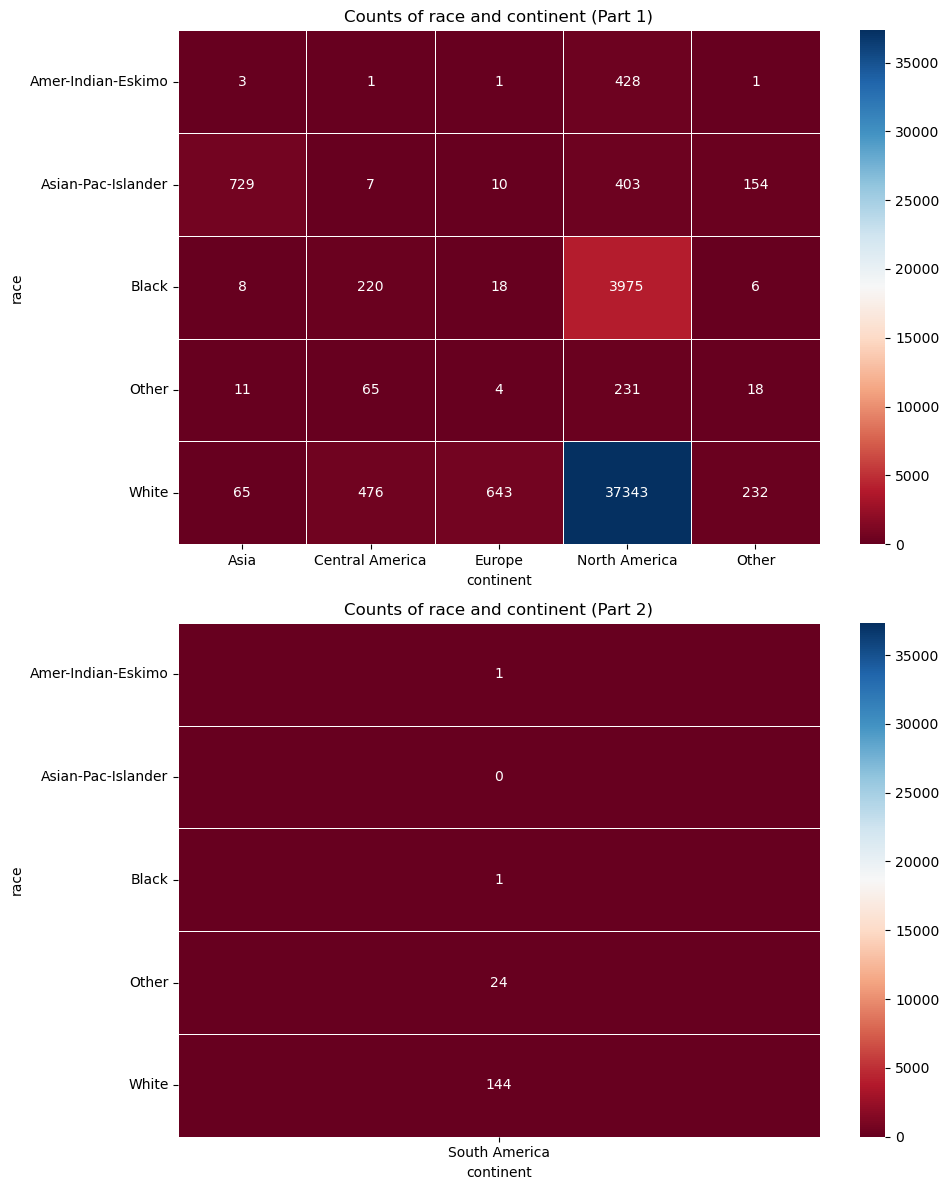

In [171]:
plot_heatmap_categorical(adult_dataset, 'race', 'continent')

We see that Asia white peaple and Asia black people are underrepresented!

We will now check underrepresented groups for age combinations.
We will first bin the age to categories

In [172]:
# Bin the age column into different age groups that are more interpretable and meaningful in regards to income
kids_range = range(0, 18)
young_adults_range = range(18, 30)
adults_range = range(30, 50)
middle_aged_range = range(50, 65)
senior_range = range(65, 100)

def map_age_to_group(age):
    if age in kids_range:
        return 'Kids'
    elif age in young_adults_range:
        return 'YoungAdults'
    elif age in adults_range:
        return 'Adults'
    elif age in middle_aged_range:
        return 'MiddleAged'
    elif age in senior_range:
        return 'Senior'
    else:
        return 'Other'
    
adult_dataset['agegroup'] = adult_dataset['age'].apply(map_age_to_group)

We will now check Underrepresented groups for age combinations with the other 3 features.

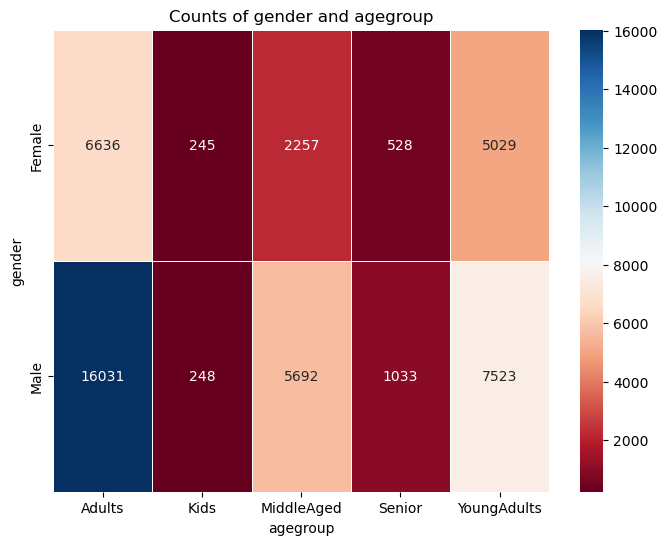

In [173]:
plot_heatmap_categorical(adult_dataset, 'gender', 'agegroup')

We found no underrepresented group. Now we will check for age and race

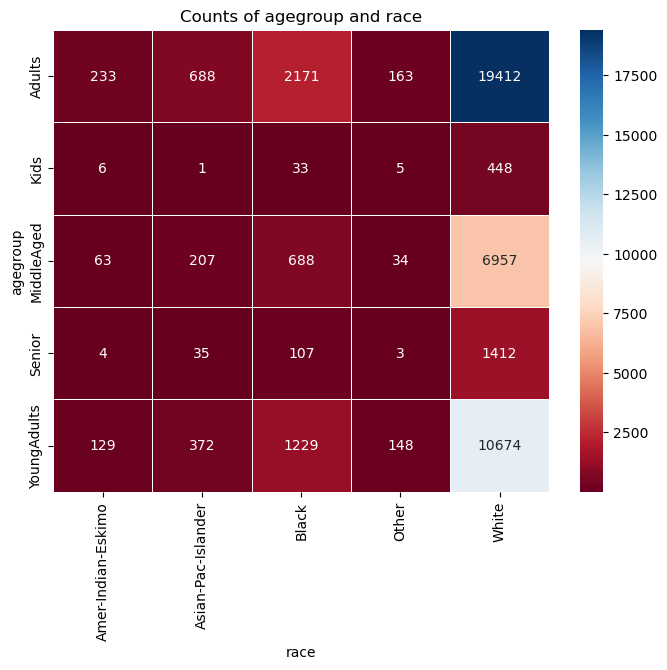

In [174]:
plot_heatmap_categorical(adult_dataset, 'agegroup', 'race')

We see underrepresentation for all non-white kids! (448 white kids vs 45 non white kids). meaning non-white kids are only 0.1% of the data.

<Figure size 800x600 with 0 Axes>

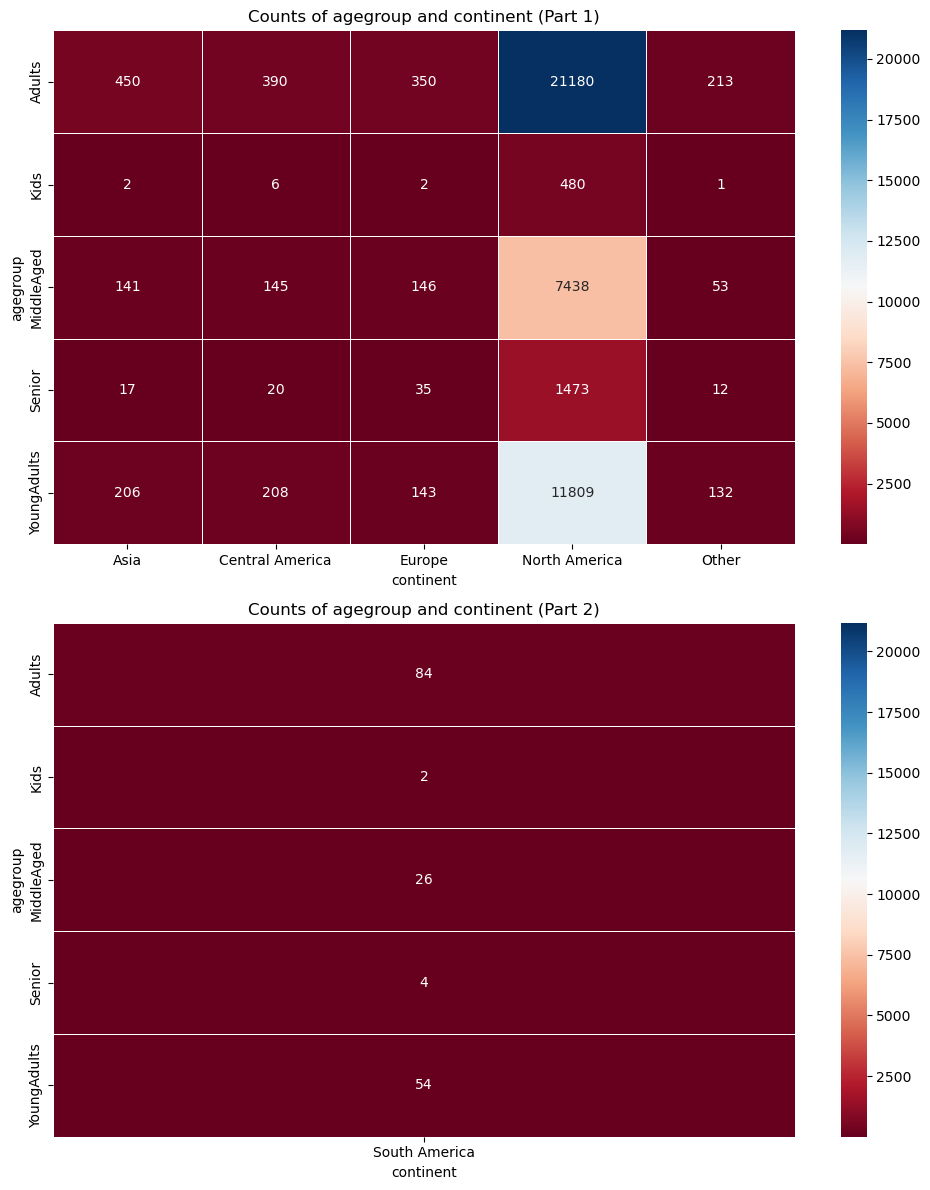

In [175]:
plot_heatmap_categorical(adult_dataset, 'agegroup', 'continent')

We see that seniors that aren't North America are underrepresented. We can take Asia-Seniors as an underrepresentred group.

We found underrepresented groups. We will now calculate the weights of the causal dag containing only the agegroup, continent, race, gender and income nodes.

5 6
True


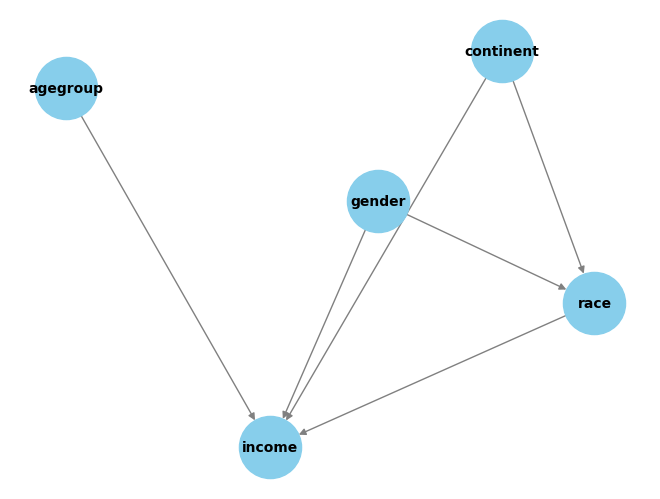

In [176]:
import networkx as nx

dag_data = [
    ('age', 'education_num'),
    ('age', 'hours_per_week'),
    ('age', 'income'),
    ('age', 'income'),
    ('age', 'marital_status'),
    ('age', 'marital_status'),
    ('age', 'occupation'),
    ('age', 'relationship'),
    ('age', 'work_class'),
    ('education_num', 'education'),
    ('education_num', 'hours_per_week'),
    ('education_num', 'income'),
    ('education_num', 'income'),
    ('education_num', 'occupation'),
    ('education_num', 'work_class'),
    ('education_num', 'work_class'),
    ('hours_per_week', 'income'),
    ('hours_per_week', 'relationship'),
    ('income', 'education'),
    ('marital_status', 'education_num'),
    ('marital_status', 'hours_per_week'),
    ('marital_status', 'income'),
    ('marital_status', 'occupation'),
    ('marital_status', 'work_class'),
    ('marital_status', 'work_class'),
    ('native_country', 'education'),
    ('native_country', 'education_num'),
    ('native_country', 'education_num'),
    ('native_country', 'hours_per_week'),
    ('native_country', 'income'),
    ('native_country', 'marital_status'),
    ('native_country', 'occupation'),
    ('native_country', 'race'),
    ('native_country', 'work_class'),
    ('occupation', 'education'),
    ('occupation', 'income'),
    ('occupation', 'occupation_category'),
    ('occupation_category', 'education'),
    ('occupation_category', 'work_class'),
    ('race', 'education_num'),
    ('race', 'hours_per_week'),
    ('race', 'income'),
    ('race', 'income'),
    ('race', 'marital_status'),
    ('race', 'occupation'),
    ('race', 'work_class'),
    ('race', 'work_class'),
    ('gender', 'education_num'),
    ('gender', 'hours_per_week'),
    ('gender', 'income'),
    ('gender', 'income'),
    ('gender', 'marital_status'),
    ('gender', 'occupation'),
    ('gender', 'race'),
    ('gender', 'relationship'),
    ('gender', 'work_class'),
    ('gender', 'work_class'),
    ('work_class', 'income'),
]

# keep only unique tuples
dag_data = list(set(dag_data))
# keep only tupples with both nodes conatained in the features: [age, gender, race, native-country, income]
relevant_features = ['age', 'gender', 'race', 'native_country', 'income']
dag_data = [row for row in dag_data if row[0] in relevant_features and row[1] in relevant_features]
# rename native_country to continent and age to agegroup
dag_data = [(row[0].replace('native_country', 'continent').replace('age', 'agegroup'), row[1].replace('native_country', 'continent').replace('age', 'agegroup')) for row in dag_data]

outcome_node = 'income'
treatment_node_to_possible_treatments = {
    'agegroup': ['YoungAdults', 'Adults', 'MiddleAged', 'Senior', 'Kids'],
    'continent': ['NorthAmerica', 'CentralAmerica', 'Asia', 'Europe', 'SouthAmerica', 'Africa', 'Other'],
    'race': ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
    'gender': ['Male', 'Female']}
    # 'income': ['<=50K', '>50K']}

# categorical_cols = ['agegroup', 'continent', 'race', 'gender', 'income']
# print()
# # convert the categorical columns to one-hot encoding
# adult_dataset = pd.get_dummies(adult_dataset, columns=categorical_cols, drop_first=True)
# for dag_data_edge in dag_data:
#     if dag_data_edge[0] in categorical_cols:
#         dag_data += [(f'{dag_data_edge[0]}_{treatment}', dag_data_edge[1]) for treatment in treatment_node_to_possible_treatments[dag_data_edge[0]]]
#     if dag_data_edge[1] in categorical_cols:
#         dag_data += [(dag_data_edge[0], f'{dag_data_edge[1]}_{treatment}') for treatment in treatment_node_to_possible_treatments[dag_data_edge[1]]]

# edit the dag to include the one-hot encoded columns
dag = nx.DiGraph(dag_data)
print(len(dag.nodes), len(dag.edges))

print(nx.is_directed_acyclic_graph(dag))
# Draw the dag

nx.draw(dag, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', pos=nx.spring_layout(dag))

In [177]:
# For each node in the DAG, calculate the ATE of each possible treatment on the income feature, using dowhy
import dowhy
from dowhy import CausalModel
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


def get_treatment_to_casual_estimate_dict(dataset, dag, treatment_node_to_possible_treatments):
    # change the income column to binary
    adult_dataset['income'] = adult_dataset['income'].apply(lambda x: 1 if x == '>50K' else 0)
    treatment_to_casual_estimate_dict = {}
    for treatment_node, possible_treatments in treatment_node_to_possible_treatments.items():
        for treatment in possible_treatments:
            dataset = adult_dataset.copy()
            dataset[treatment_node] = dataset[treatment_node].apply(lambda x: 1 if x == treatment else 0)
            model = CausalModel(
                data=dataset,
                treatment=treatment_node,
                outcome=outcome_node,
                graph=dag
            )
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.generalized_linear_model",
                                            confidence_intervals=False,
                                            test_significance=False,
                                            method_params = {
                                                'num_null_simulations':10,
                                                'num_simulations':10,
                                                'num_quantiles_to_discretize_cont_cols':10,
                                                'fit_method': "statsmodels",
                                                'glm_family': sm.families.Binomial(), # logistic regression
                                                'need_conditional_estimates':False
                                            },)
            print(f'Treatment: {treatment_node}={treatment}, ATE: {causal_estimate.value}')
            treatment_to_casual_estimate_dict[(treatment_node, treatment)] = causal_estimate.value
    return treatment_to_casual_estimate_dict
    


In [178]:
treatment_to_casual_estimate_dict = get_treatment_to_casual_estimate_dict(adult_dataset, dag, treatment_node_to_possible_treatments)

Treatment: agegroup=YoungAdults, ATE: -0.2599594847503504
Treatment: agegroup=Adults, ATE: 0.1375747270096538
Treatment: agegroup=MiddleAged, ATE: 0.12711090740031447
Treatment: agegroup=Senior, ATE: -0.030204730109130357
Treatment: agegroup=Kids, ATE: -0.25057568914731665
Treatment: continent=NorthAmerica, ATE: 0.0
Treatment: continent=CentralAmerica, ATE: 0.0
Treatment: continent=Asia, ATE: 0.02726047786646657
Treatment: continent=Europe, ATE: 0.044622519213686374
Treatment: continent=SouthAmerica, ATE: 0.0
Treatment: continent=Africa, ATE: 0.0
Treatment: continent=Other, ATE: -0.016765011562265425
Treatment: race=White, ATE: 0.09613370447585587
Treatment: race=Black, ATE: -0.10239014544723571
Treatment: race=Asian-Pac-Islander, ATE: 0.05069867596631719
Treatment: race=Amer-Indian-Eskimo, ATE: -0.12070874865038203
Treatment: race=Other, ATE: -0.07551121804917774
Treatment: gender=Male, ATE: 0.18705128905589224
Treatment: gender=Female, ATE: -0.18883306043328144


In [95]:
# Select features for clustering
scalar_features_for_voroni = ['age', 'educational-num']

# Prepare the data for clustering
X = adult_dataset[scalar_features_for_voroni].copy()

In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [97]:
from sklearn.cluster import KMeans

# Set number of clusters
k = 10

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
X['cluster'] = kmeans.fit_predict(X_scaled)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


X Shape: (48842, 3)
First few rows of X:
    age  educational-num  cluster
0   25                7        8
1   38                9        0
2   28               12        7
3   44               10        5
4   18               10        4


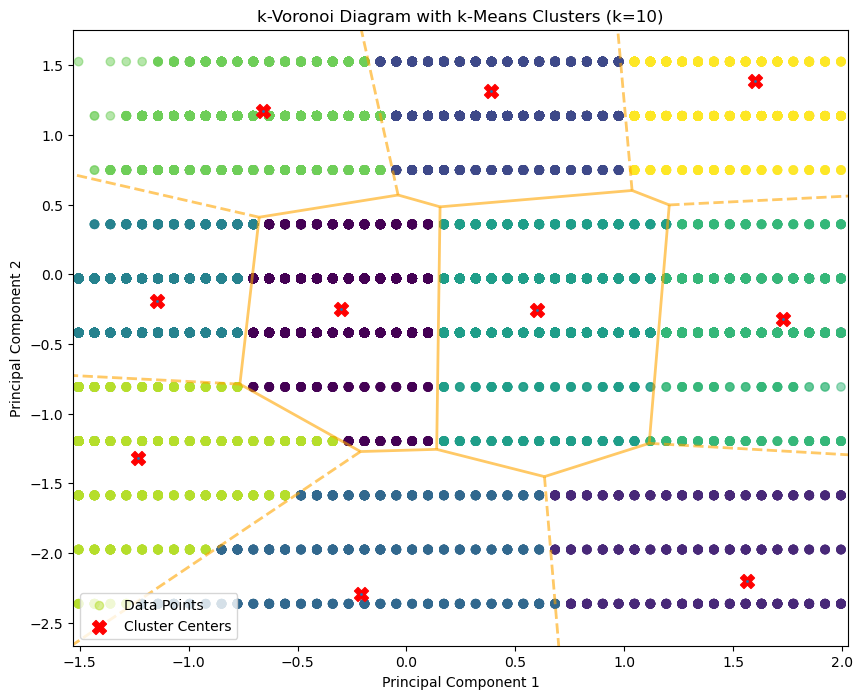

In [98]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Assuming cluster_centers, X, and adult_dataset['cluster'] are defined correctly
# Create Voronoi diagram based on cluster centers in PCA space
vor = Voronoi(cluster_centers)
print("X Shape:", X.shape)
print("First few rows of X:\n", X.head())
# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the Voronoi diagram on the created axes
voronoi_plot_2d(
    vor,
    ax=ax,
    show_vertices=False,
    line_colors='orange',
    line_width=2,
    line_alpha=0.6,
    point_size=2
)

# Scatter plot of data points colored by cluster on the same axes
scatter = ax.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=X['cluster'],
    cmap='viridis',
    alpha=0.5,
    label='Data Points'
)

# Scatter plot of cluster centers
ax.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='X',
    s=100,
    label='Cluster Centers'
)

# Adding title and labels
ax.set_title('k-Voronoi Diagram with k-Means Clusters (k=10)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Optional: Add a legend
ax.legend()

# Show the plot
plt.show()

In [99]:
# Calculate cluster sizes
cluster_sizes = X['cluster'].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_sizes)

Cluster Sizes:
cluster
0    9327
1    1585
2    5613
3    1557
4    8639
5    7806
6    3943
7    5877
8    2274
9    2221
Name: count, dtype: int64


In [100]:
# Define threshold for underrepresentation
threshold = 0.04 * len(X)  # 4% of the dataset

# Identify underrepresented clusters
underrepresented_clusters = cluster_sizes[cluster_sizes < threshold].index.tolist()
print("\nUnderrepresented Clusters:", underrepresented_clusters)


Underrepresented Clusters: [1, 3]


In [101]:
# Inverse transform the scaled data to get original values
X[['age_original', 'education_num_original']] = scaler.inverse_transform(X_scaled)

# Analyze underrepresented clusters
for cluster in underrepresented_clusters:
    print(f"\nCluster {cluster} Summary:")
    cluster_data = X[X['cluster'] == cluster]
    print(cluster_data[['age_original', 'education_num_original']].describe())


Cluster 1 Summary:
       age_original  education_num_original
count   1585.000000             1585.000000
mean      60.059306                4.418297
std        8.387040                1.308401
min       48.000000                1.000000
25%       53.000000                4.000000
50%       59.000000                4.000000
75%       65.000000                6.000000
max       90.000000                6.000000

Cluster 3 Summary:
       age_original  education_num_original
count   1557.000000             1557.000000
mean      35.781631                4.172768
std        7.370726                1.385874
min       17.000000                1.000000
25%       31.000000                3.000000
50%       36.000000                4.000000
75%       42.000000                5.000000
max       48.000000                6.000000
